In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## For google colab

In [ ]:
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/SUP/4A/SDD/hackaton_ocean/ocean-eddy-detection'

# Pre-processing

In [21]:
from torchvision import datasets, transforms

image_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
    ]
)

In [31]:
class TrainDataset():
    def __init__(self, path):

        eddies_train = xr.open_dataset(path + '/eddies_train.nc')
        X_train = xr.open_dataset(path + '/OSSE_U_V_SLA_SST_train.nc')
        
        y = eddies_train.eddies.values
        
        X_verti = X_train.vomecrtyT.values
        X_hori = X_train.vozocrtxT.values
        X_SSH = X_train.sossheig.values
        X_SST = X_train.votemper.values

        X_verti = np.nan_to_num(X_verti, nan=0)
        X_hori = np.nan_to_num(X_hori, nan=0)
        X_SSH = np.nan_to_num(X_SSH, nan=0)
        X_SST = np.nan_to_num(X_SST, nan=0)
        
        ##Normalisation
        X_verti = ( X_verti - np.min(X_verti) )/( np.max(X_verti) - np.min(X_verti) )
        X_hori = ( X_hori - np.min(X_hori) )/( np.max(X_hori) - np.min(X_hori) )
        X_SSH = ( X_SSH - np.min(X_SSH) )/( np.max(X_SSH) - np.min(X_SSH) )
        X_SST = ( X_SST - np.min(X_SST) )/( np.max(X_SST) - np.min(X_SST) )
        
        
        ##Transformation
        X = np.array([X_verti, X_hori, X_SSH, X_SST])
        X = X.transpose((1,0,2,3))
        y = np.nan_to_num(y, nan=3)
        
        
        self.X_train = torch.tensor(X)
        self.y_train = torch.tensor(y, dtype=torch.long)
        self.image_transforms = image_transforms
        
        
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        
        x = self.X_train[idx]
        y = self.y_train[idx]
        
        x = self.image_transforms(x)
        
        return self.X_train[idx], self.y_train[idx]

In [32]:
path = 'ocean-eddy-detection/' # local
trainDataset = TrainDataset(path)
train_dataloader = DataLoader(trainDataset, batch_size=4, shuffle=True)

torch.Size([4, 4, 357, 717])


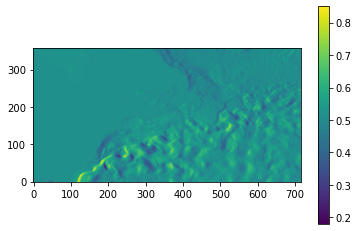

In [33]:
img, label = next(iter(train_dataloader))
print(img.shape)
plt.imshow(img[0][0], origin='lower')
plt.colorbar()

torch.Size([4, 4, 357, 717])


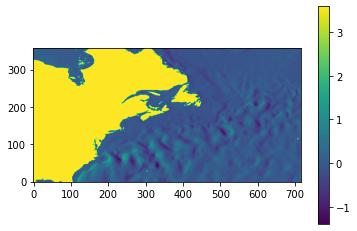

In [16]:
img, label = next(iter(train_dataloader))
print(img.shape)
plt.imshow(img[0][0], origin='lower')
plt.colorbar()

In [ ]:
class Unet(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(4, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 4, kernel_size=1)
        )
    

    def forward(self, x, mask):
        
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        xmiddle = self.middleU(x3)

        xup0_1 = torch.cat((x3,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x2,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x1,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        return xup3


In [ ]:
class Adapted_loss(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss = nn.CrossEntropyLoss()
      
    def forward(self, prediction, target):
      mask = target[0]!=3
      y = target[:,mask]
      ypred = prediction[:,:,mask]
      return self.loss(ypred, y)

#EXEMPLE
#loss = Adapted_loss()
#loss(ypred, y)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move input and target tensors to the device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X, trainDataset.mask).to(device)
        pred = pred.to(dtype=torch.float64)
    
        loss = loss_fn(pred, y.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss and accuracy
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
model = Unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
loss_fn = Adapted_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
print("Done!")

In [ ]:
x_test, label_test = next(iter(train_dataloader))

print(label_test.shape)
x_test = x_test.to(device)[0]
plt.imshow(label_test[0], origin='lower')
plt.show()
plt.imshow(np.argmax(model(x_test.reshape(1,4,357,717), 1).softmax(dim=1).cpu().detach().numpy(), axis=1)[0], origin='lower')